In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
scratch_dir = "C:/Users/Checkout/Desktop/GWAR/Project/Dataset/NEU-DET/train/images/scratches"
patch_dir = "C:/Users/Checkout/Desktop/GWAR/Project/Dataset/NEU-DET/train/images/patches"

# Training 240 images

In [3]:
def load_dataset(directory):
    data = []
    labels = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0  
        data.append(img_array)
        labels.append(0 if directory.endswith('scratches') else 1) 
    return np.array(data), np.array(labels)

# Training 8 images

In [3]:
import random

def load_eight_dataset(directory, num_samples=8):
    data = []
    labels = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if os.path.isfile(img_path):  # Check if it's a file
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0
            data.append(img_array)
            labels.append(0 if directory.endswith('scratches') else
                          1)
    
    # Randomly select num_samples images from the data
    if len(data) > num_samples:
        selected_indices = random.sample(range(len(data)), num_samples)
        data = [data[i] for i in selected_indices]
        labels = [labels[i] for i in selected_indices]
    
    return np.array(data), np.array(labels)


In [5]:
scratch_data, scratch_labels = load_dataset(scratch_dir)
patch_data, patch_labels = load_dataset(patch_dir)

NameError: name 'load_dataset' is not defined

In [5]:
data = np.concatenate((scratch_data, patch_data), axis=0)
labels = np.concatenate((scratch_labels, patch_labels), axis=0)

In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5000 - loss: 1.3837 - val_accuracy: 1.0000 - val_loss: 0.0580
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 1.0000 - loss: 0.0516 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0222
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0275
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0296
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0282
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0238
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 1.0000 - loss: 7.5826e-04 - val_accuracy: 1.0000 - val_loss

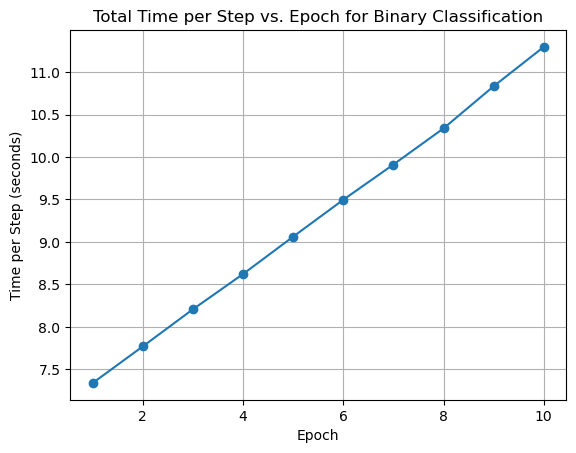

In [19]:
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import Callback

data_resized = []
for img in data:
    img_resized = tf.image.resize(img, (224, 224))
    data_resized.append(img_resized)

class TimePerStepCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        self.epoch_times.append(end_time - self.start_time)
        
data_resized = np.array(data_resized)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(6, activation='softmax')  
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


time_callback = TimePerStepCallback()
history = model.fit(data_resized, labels, epochs=10, batch_size=32, validation_split=0.2, callbacks=[time_callback], verbose=1)

# Calculate cumulative time per step
cumulative_time_per_step = np.cumsum(time_callback.epoch_times)

# Plotting
plt.plot(range(1, len(cumulative_time_per_step) + 1), cumulative_time_per_step, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time per Step (seconds)')
plt.title('Total Time per Step vs. Epoch for Binary Classification')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

patch_val_dir = "C:/Users/Checkout/Desktop/GWAR/Project/Dataset/NEU-DET/validation/images/patches"
scratch_val_dir = "C:/Users/Checkout/Desktop/GWAR/Project/Dataset/NEU-DET/validation/images/scratches"

In [22]:
def predict_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
   
    class_labels = ['Scratch', 'Patch']
    
    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)
    
    # Get the predicted class label
    predicted_class = class_labels[predicted_class_index]
    
    return predicted_class


In [23]:
def evaluate_model(model, val_scratch_dir, val_patch_dir):
    true_labels = []
    predicted_labels = []

    # Evaluate on crazing images
    for img_name in os.listdir(val_scratch_dir):
        img_path = os.path.join(val_scratch_dir, img_name)
        true_labels.append(0)  # True label for crazing
        prediction = predict_image(img_path)
        predicted_labels.append(0 if prediction == "Scratch" else 1)

    # Evaluate on inclusion images
    for img_name in os.listdir(val_patch_dir):
        img_path = os.path.join(val_patch_dir, img_name)
        true_labels.append(1)  # True label for inclusion
        prediction = predict_image(img_path)
        predicted_labels.append(0 if prediction == "Scratch" else 1)

   
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

    return accuracy, precision, recall, confusion_mat



In [24]:
accuracy, precision, recall, confusion_mat = evaluate_model(model, scratch_val_dir, patch_val_dir)
print("Accuracy for training 8 images:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(confusion_mat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

In [4]:
scratch_data, scratch_labels = load_eight_dataset(scratch_dir)
patch_data, patch_labels = load_eight_dataset(patch_dir)

In [1]:
data = np.concatenate((scratch_data, patch_data), axis=0)
labels = np.concatenate((scratch_labels, patch_labels), axis=0)

NameError: name 'np' is not defined